In [1]:
# Import Packages
import pandas as pd
from pandas import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [2]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [3]:
# Load Data
data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

In [4]:
cust_filter = data['cust_id'] == 'klant_69'
date_filter = data['procesdag'].dt.dayofweek <= 4
data = data.where(date_filter & cust_filter).dropna()
#data = data.where(cust_filter).dropna()

data['procesdag']=pd.to_datetime(data['procesdag'])
data = data.set_index(data.procesdag, drop=True)
data = data['2016-01-01':'2020-01-01']

In [5]:
data.drop(['procesdag'], axis='columns', inplace=True)
data.drop(['aantal_pakketten_volgende_dag'], axis='columns', inplace=True)

In [6]:
data.head()

,cust_id,aantal_pakketten,validation_column
procesdag,,,
2016-01-01,klant_69,0.0,train
2016-01-04,klant_69,330.0,train
2016-01-05,klant_69,301.0,train
2016-01-06,klant_69,391.0,train
2016-01-07,klant_69,301.0,train


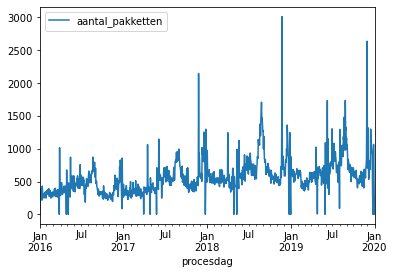

In [7]:
data.plot()

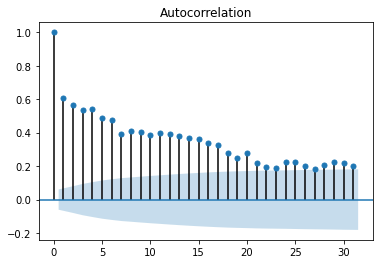

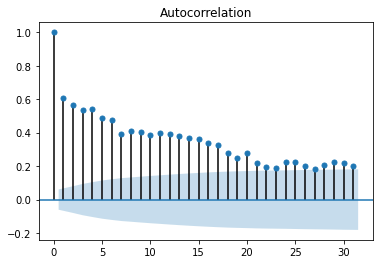

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['aantal_pakketten'])

In [9]:
data_diff = data['aantal_pakketten'].diff()
data_diff.fillna(0, inplace=True)
data_diff.head()

procesdag
2016-01-01      0.0
2016-01-04    330.0
2016-01-05    -29.0
2016-01-06     90.0
2016-01-07    -90.0
Name: aantal_pakketten, dtype: float64

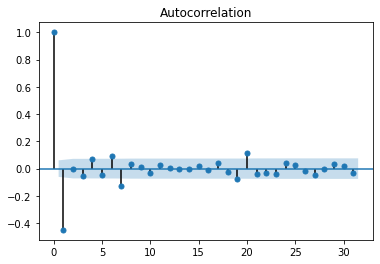

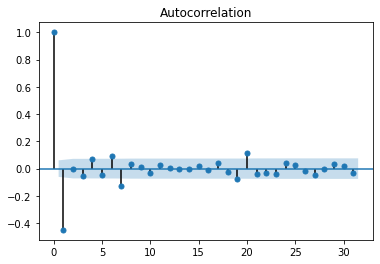

In [10]:
plot_acf(data_diff)

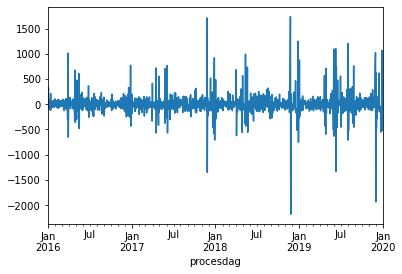

In [11]:
data_diff.plot()

# TRAIN AND TEST

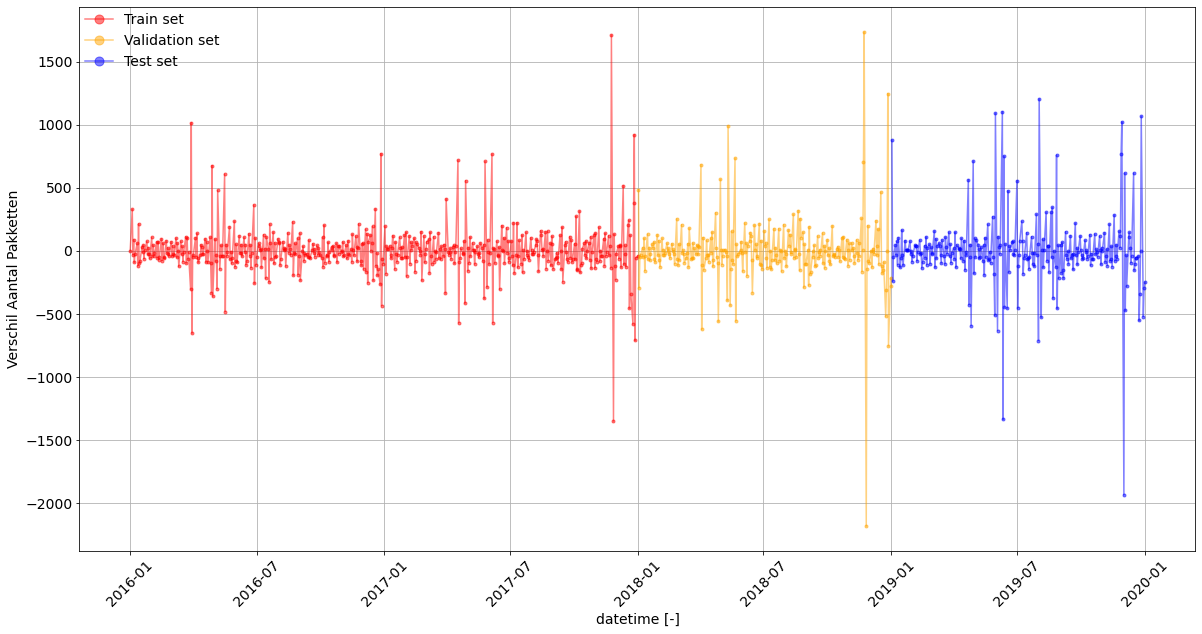

In [12]:
from sklearn.model_selection import train_test_split

y = data_diff
X = data.index

train_size = 0.75
val_size = 0.25

split_index_val = int(data.shape[0]*(train_size-val_size))
split_index_test = int(data.shape[0]*train_size)

X_train = X[:split_index_val]
X_val = X[split_index_val:split_index_test]
X_test = X[split_index_test:]

y_train = y[:split_index_val]
y_val = y[split_index_val:split_index_test]
y_test = y[split_index_test:]

X_train_values = data[:split_index_val] # get the datetime values of X_train
X_val_values = data[split_index_val:split_index_test]
X_test_values = data[split_index_test:]

plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_val_values.index, y_val, '.-', color='orange', label='Validation set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Verschil Aantal Pakketten', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)
plt.grid()

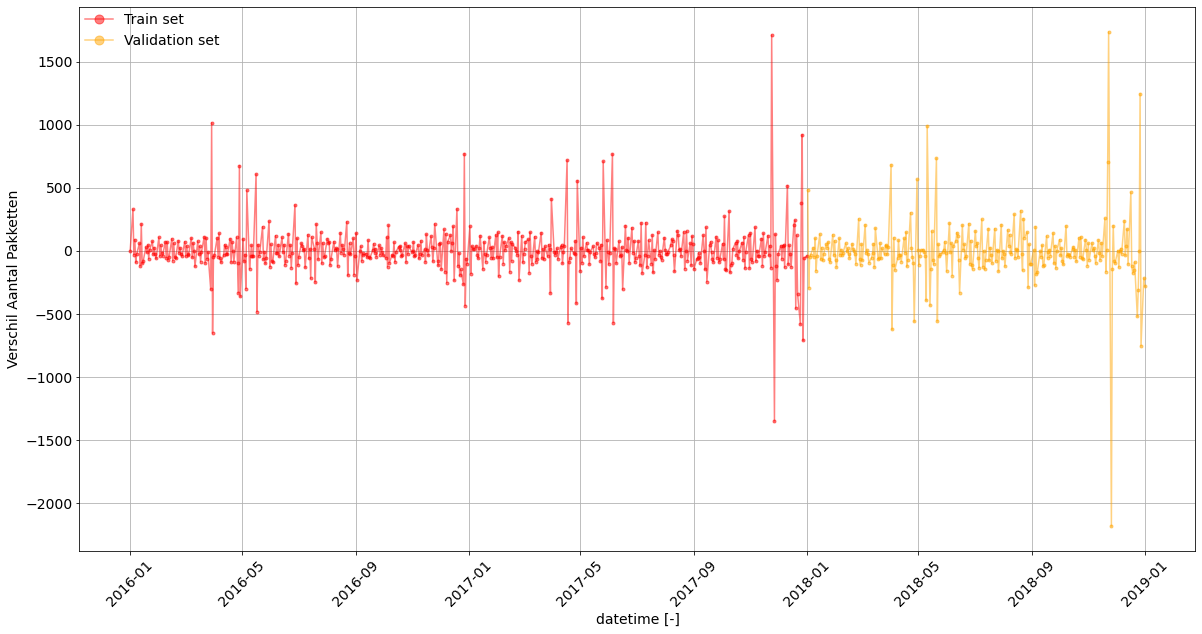

In [13]:
from sklearn.model_selection import train_test_split

y = data_diff[:'2019-01-01']
X = data.index

train_size = 0.75
val_size = 0.25

split_index_val = int(data.shape[0]*(train_size-val_size))
split_index_test = int(data.shape[0]*train_size)

X_train = X[:split_index_val]
X_val = X[split_index_val:split_index_test]
#X_test = X[split_index_test:]

y_train = y[:split_index_val]
y_val = y[split_index_val:split_index_test]
#y_test = y[split_index_test:]

X_train_values = data[:split_index_val] # get the datetime values of X_train
X_val_values = data[split_index_val:split_index_test]
#X_test_values = data[split_index_test:]

plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_val_values.index, y_val, '.-', color='orange', label='Validation set', alpha=0.5)
#plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Verschil Aantal Pakketten', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)
plt.grid()

In [14]:
train_end = datetime(2018,1,1)
val_end = datetime(2019,1,1)

train_data = y[:train_end]
val_data = y[train_end + timedelta(days=1):val_end]

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
my_order = (1,0,1)
my_seasonal_order = (0, 1, 1, 12)

In [16]:
rolling_predictions = val_data.copy()
for train_end in val_data.index:
    train_data = y[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B wil

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [17]:
rolling_residuals = val_data - rolling_predictions

Root Mean Squared Error: 184.32904963742237


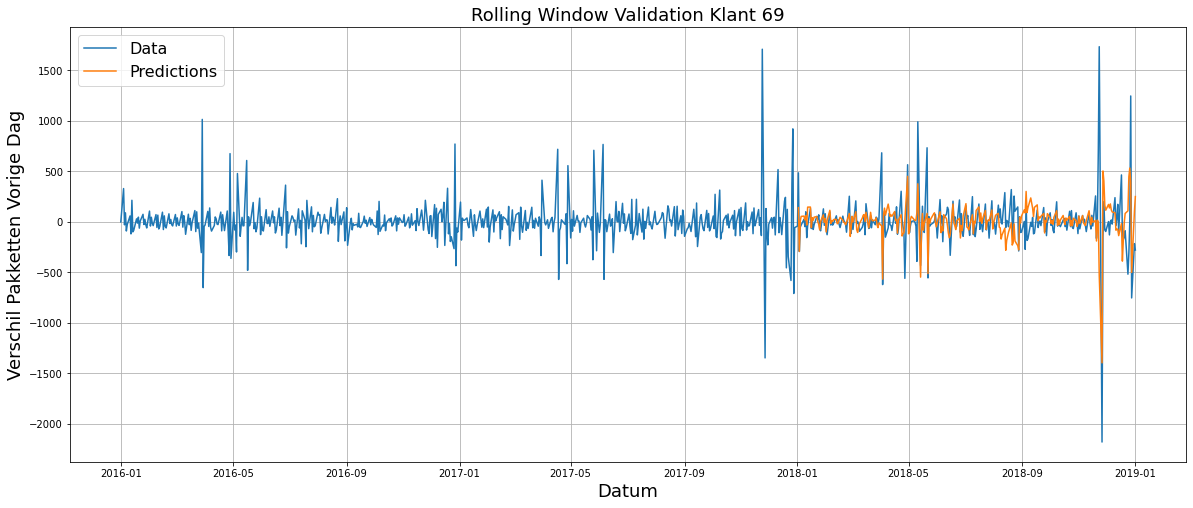

In [18]:
plt.figure(figsize=(20,8))

plt.plot(y)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid()
plt.xlabel('Datum',fontsize= 18)
plt.ylabel('Verschil Pakketten Vorige Dag',fontsize= 18)
plt.title('Rolling Window Validation Klant 69',fontsize= 18)
residuals = data_diff - model_fit.fittedvalues
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 184.32904963742237


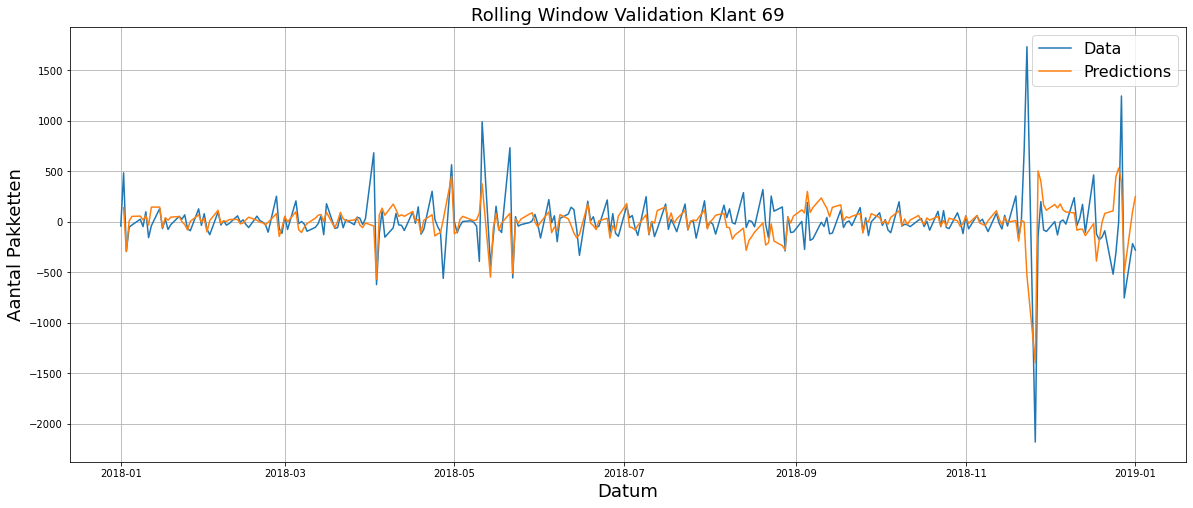

In [19]:
plt.figure(figsize=(20,8))

plt.plot(y['2018-01-01':'2019-01-01'])
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid()
plt.xlabel('Datum',fontsize= 18)
plt.ylabel('Aantal Pakketten',fontsize= 18)
plt.title('Rolling Window Validation Klant 69',fontsize= 18)
residuals = data_diff - model_fit.fittedvalues
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))